In [1]:
from PC import PC
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [2]:
def getEdges(dictGraph):
    edges = []
    for node1, addjacents in dictGraph.items():
        for node2 in addjacents:
            edges.append((node1, node2))
    return edges

In [3]:
data = pd.read_csv('data/train.csv')
data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'], inplace=True)

data['Sex'] = data['Sex'].apply(lambda x: 1 if x=='male' else 0)

data.dropna(inplace=True)

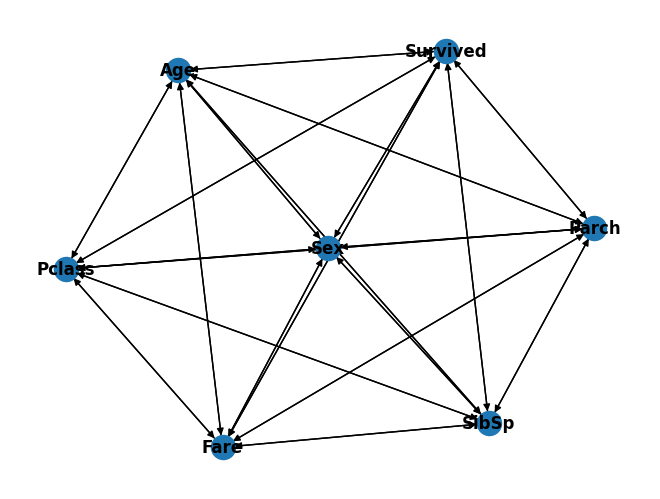

In [4]:
originalGraph = {column: set(data.columns.drop(column)) \
                            for column in data.columns}

G = nx.DiGraph(getEdges(originalGraph))
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

In [5]:
def discretize(data, column, bins):
    data[column] = pd.cut(data[column], bins, labels=False)

# Age and Fare discretization
discretize(data, 'Age', 5)
discretize(data, 'Fare', 5)

In [6]:
data_train = data.sample(frac=0.8, random_state=42)
data_test = data.drop(data_train.index)

In [7]:
pc = PC(0.25, exogeneous=['Age', 'Sex'], endogeneous=['Survived'], directional=True, maxSeparatingDepth=2)

graph, separatingSets = pc.causalDiscovery(data_train)

Depth 0 completed
Depth 1 completed
Depth 2 completed


In [8]:
print('Number of disconnections:', len(separatingSets))
for separatingSet in separatingSets:
    print(separatingSet[0], 'are sepated by', separatingSet[1])

Number of disconnections: 11
('Survived', 'Age') are sepated by ('Parch',)
('Survived', 'SibSp') are sepated by ('Pclass',)
('Survived', 'Fare') are sepated by ('Pclass',)
('Pclass', 'SibSp') are sepated by ('Survived',)
('Pclass', 'Parch') are sepated by ('Sex',)
('Sex', 'Age') are sepated by ('Parch',)
('Sex', 'Fare') are sepated by ('Pclass',)
('Age', 'SibSp') are sepated by ('Parch',)
('Age', 'Fare') are sepated by ('Pclass',)
('Pclass', 'Sex') are sepated by ('Fare', 'Age')
('Sex', 'SibSp') are sepated by ('Parch', 'Survived')


In [9]:
for key, value in graph.items():
    value.discard('PassengerId')

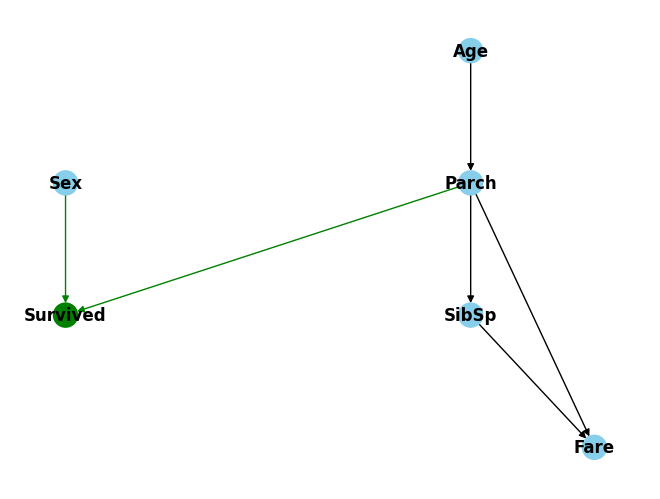

In [10]:
def plotGraph(graph):
        G = nx.DiGraph(getEdges(graph))

        # For a beautiful graph
        pos = nx.nx_agraph.graphviz_layout(G, prog='dot')
        node_color = ['green' if node == 'Survived' else 'skyblue' for node in G.nodes()]
        edge_color = ['green' if edge[1] == 'Survived' else 'black' for edge in G.edges()]

        nx.draw(G, pos, node_color=node_color, edge_color=edge_color, 
                with_labels=True, font_weight='bold')
        plt.show()

plotGraph(graph)

In [11]:
X_features = list(graph.keys())
X_features.remove('Survived')

X_train = data_train[X_features]
X_test = data_test[X_features]

y_train = data_train['Survived']
y_test = data_test['Survived']

In [12]:
from pgmpy.models import BayesianNetwork

BN = BayesianNetwork()

BN.add_nodes_from(graph.keys())
for node, addjacent in graph.items():
    for addj in addjacent:
        BN.add_edge(node, addj)

In [13]:
BN.fit(data_train)

In [14]:
y_pred_BN = BN.predict(X_test)['Survived']

  0%|          | 0/74 [00:00<?, ?it/s]

In [15]:
from sklearn.metrics import f1_score

f1_BN = f1_score(y_test, y_pred_BN)

In [16]:
NB = BayesianNetwork([(feature, 'Survived') for feature in X_features])

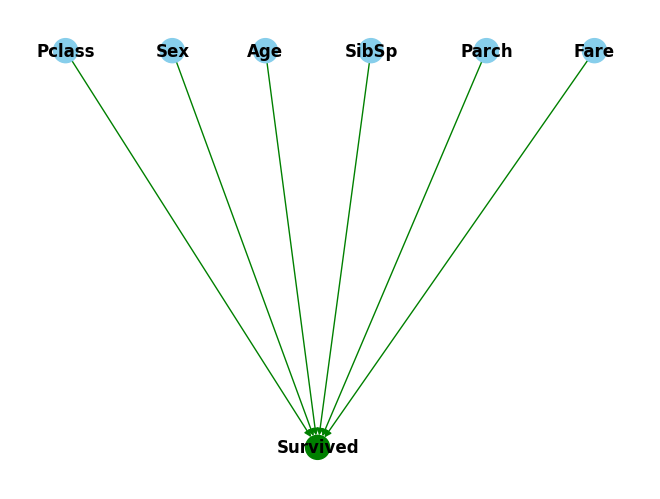

In [17]:
plotGraph({feature: {'Survived'} for feature in X_features})

In [18]:
NB.fit(data_train)

In [19]:
y_pred_NB = NB.predict(X_test)

  0%|          | 0/74 [00:00<?, ?it/s]

In [20]:
f1_NB = f1_score(y_test, y_pred_NB)
print("F1 Score:\nBayesian Network ->", f1_BN, "\nNaive Bayes ->", f1_NB)

F1 Score:
Bayesian Network -> 0.7037037037037038 
Naive Bayes -> 0.608695652173913


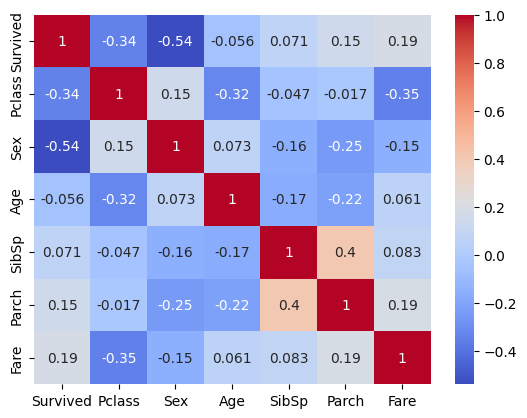

In [21]:
import seaborn as sns

corr_matrix = data.corr(method='kendall')

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()